# Dimension reduction of genotype data

This notebook is intended to explore population structure through dimension reduction of genotype data from the Thousand Genomes Project (1KGP). Data is available here:

* http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/release/20130502/supporting/hd_genotype_chip/
* http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/phase3/

We will use chromosome 22 derived from the following files:
* ALL.wgs.nhgri_coriell_affy_6.20140825.genotypes_has_ped.vcf.gz
* affy_samples.20141118.panel
* 20131219.populations.tsv

This code was written by Alex Diaz-Papkovich and Simon Gravel.

In [1]:
# Import libraries. 
# Generate images in the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import collections
from collections import defaultdict
import gzip
#import itertools
import numpy as np
import os
import time

# Dimension reduction tools
from sklearn.decomposition import PCA as PCA
from sklearn.manifold import TSNE
import umap 

First set up our files.

In [2]:
data_dir = 'data'

vcf_name = '1kgp_data_chr22.vcf.gz'
pop_desc_name = '20131219.populations.tsv'
pop_file_name = 'affy_samples.20141118.panel'

vcf_file = os.path.join(data_dir, vcf_name)
population_description_file = os.path.join(data_dir, pop_desc_name)
population_file = os.path.join(data_dir, pop_file_name)

This function reads in genetic data from VCF files. Other libraries exist to carry this out as well.

In [3]:
# Code to read in the SNP data. Assign every SNP a value of {0,1,2} relative to reference genome.
from collections import Counter

class snp(object):

    def __init__(self, line, select=False, autosome_only =True):
        """The initialization method takes in a line from the vcf file, as a string, 
        and records the relevant information. 
        line: a string from a vcf file
        select: a list of positions of individuals to be analyzed, where positions run from 0 to 
        nInd-1, the number of individuals
        """ 
        
        split_line = line.split()  #  First break down the line into a list of each field
        
        self.failed = False  # A label that we will set to True if something goes wrong.
        
        if line.startswith('#'):
            self.failed = True
            self.failure_cause = "line was a header line, not a snp"
            return
        
        if len(split_line)<=5:
            self.failed = True
            self.failure_cause = "incorrectly formatted line, should have at least 5 fields " + line
            return
          
        self.chrom = split_line[0]
        if autosome_only:
            if self.chrom not in ["%d" % (i,) for i in range(1,23)]:
                self.failed = True
                self.failure_cause = "not recognized as an autosome while autosome_only set to True"
                return
        
        self.chrom = int(split_line[0]) # Chromosome (numbered)
        self.position = int(split_line[1])  # The coordinates of the snp
        self.rid = split_line[2] # Name/Record ID
        self.ref_allele = split_line[3]
        self.alt_allele = split_line[4] # The alterate allele according to the vcf; also a string 
        # Only accept snps in ACGT. 
        if self.ref_allele not in ["A","C","G","T"] or self.alt_allele not in ["A","C","G","T"]:
            self.failed = True
            self.failure_cause = "ref or alt not in ACGT"
            return
        self.filter = split_line[6]  # See vcf format specifications for the interpretation of 
                                    # the filter field
        if self.filter not in ['PASS', '.'] :  # PASS indicates a SNP that passed all QC filters.
            self.failed = True
            self.failure_cause = self.filter
            return
              
        self.genotype_strings = split_line[9:]

        # Prepare a list that will contain the transformed genotypes. 
        # Since we already know how long the list will be, it makes sense 
        # to create an array of zeros of the same length as self.gtypes, 
        
        self.genotype_array = np.zeros(len(self.genotype_strings), dtype = np.int8)             

        # Count the number of each genotype. 
        # There may be different strings giving the same genotype so we increment the 
        # counts found so far for the genotype by the number of times the  
        # For example, "0/0" and "0\0" give homref, and "0|1" and "1|0" give het
        
        n_missing = 0
        for index,genotype_string in enumerate(self.genotype_strings):
            if genotype_string == './.':
                n_missing +=1 
                self.genotype_array[index]=-1
                continue # missing data will be left as 0
            allele_0 = genotype_string[0] # Get the first allele (as a string)
            allele_1 = genotype_string[2]
            if (allele_0=='1' and allele_1=='1'): # Use rstrip because windows machines will occasionally have extra \n
                self.genotype_array[index]=2
            elif ((allele_0=='0' and allele_1=='1') or (allele_0=='1' and allele_1=='0')):
                self.genotype_array[index]=1   
            elif (allele_0=='0' and allele_1=='0'):
                # The array was initialized to zero, so nothing to do here!
                continue
            else:
                print(("unknown genotype", genotype_string))
                self.failed=True
                self.failedreason="unknown genotype"
                return

Read in the genetic data.

In [4]:
# Specify which lines to skip (value of 1 means don't skip any lines)
number_of_lines_to_skip = 1

start_time = time.time()

genotype_matrix = []  # Will contain our numerical genotype matrix. 
genotype_positions = []
genotype_names = []
x = 0
error_count = 0

with gzip.open(vcf_file,'rt') as f:
    count = 0
    for line in f:
        count+=1
        if count % number_of_lines_to_skip == 0:
            if line.startswith("#") or snp(line).failed:
                if snp(line).failure_cause != "line was a header line, not a snp":
                    error_count += 1
                    if x < 10:
                        print('Failed: ' + snp(line).failure_cause)
                        x+=1
                continue
            
            return_snp = snp(line)
            genotype_matrix.append(return_snp.genotype_array)
            genotype_names.append(return_snp.rid)
            genotype_positions.append([return_snp.chrom, return_snp.position])

end_time = time.time()
            
print("Run time in seconds: " + str(end_time - start_time))

Run time in seconds: 27.40729069709778


In [5]:
transposed_genotype_matrix = np.array(genotype_matrix).transpose()

In [6]:
population_by_individual = defaultdict(int)
individuals_by_population = defaultdict(list)  # A dictionary containing all the individuals in a given population
indices_of_population_members = defaultdict(list)

idx = 0

for line in open(population_file,'r'):
    split_line = line.split()
    if split_line[0] == 'sample':  # header line
        continue

    sample_name = split_line[0]
    population_name = split_line[1]
    population_by_individual[sample_name] = population_name
    individuals_by_population[population_name].append(sample_name) 
    indices_of_population_members[population_name].append(idx)
    
    idx+=1

populations = list(individuals_by_population.keys())

In [7]:
# The path to the place where you put the population name file.
name_by_code = {}  # A dictionary giving the full name of each population code
pop_by_continent = {}  # A dictionary giving the code of each population within a continent  
continent_by_population = {}  # A dictionary giving the continent for each population code
for line in open(population_description_file,'r'):
    split_line = line.split('\t')
    if split_line[0] in ['Population Description','Total','']:  # header or footer
        continue
    name_by_code[split_line[1]] = split_line[0]
    continent_by_population[split_line[1]] = split_line[2]
    try: 
        pop_by_continent[split_line[2]].append(split_line[1])
    except KeyError:
        pop_by_continent[split_line[2]] = [split_line[1]]

continents = list(pop_by_continent.keys()) 
    
    
# Populations listed by continent
pops=[]
for continent in continents:
    pops.extend(pop_by_continent[continent])

In [8]:
color_dict = {}
color_dict['CDX'] = '#393b79'
color_dict['CHB'] = '#5254a3'
color_dict['JPT'] = '#6b6ecf'
color_dict['KHV'] = '#9c9ede'
color_dict['CHS'] = '#393b79'
color_dict['BEB'] = '#637939'
color_dict['GIH'] = '#8ca252'
color_dict['ITU'] = '#b5cf6b'
color_dict['PJL'] = '#cedb9c'
color_dict['STU'] = '#637939'
color_dict['ASW'] = '#8c6d31'
color_dict['ACB'] = '#bd9e39'
color_dict['ESN'] = '#e7ba52'
color_dict['GWD'] = '#e7cb94'
color_dict['LWK'] = '#8c6d31'
color_dict['MSL'] = '#bd9e39'
color_dict['YRI'] = '#e7ba52'
color_dict['GBR'] = '#843c39'
color_dict['FIN'] = '#ad494a'
color_dict['IBS'] = '#d6616b'
color_dict['TSI'] = '#e7969c'
color_dict['CEU'] = '#843c39'
color_dict['CLM'] = '#7b4173'
color_dict['MXL'] = '#a55194'
color_dict['PEL'] = '#ce6dbd'
color_dict['PUR'] = '#de9ed6'
color_dict['CHS'] = '#9e9ac8'
color_dict['STU'] = '#c7e9c0'
color_dict['LWK'] = '#7f3b08'
color_dict['MSL'] = '#b35806'
color_dict['YRI'] = '#e08214'
color_dict['CEU'] = '#d6604d'

# Dimension reduction

## PCA

First we generate our prinicipal component projection

In [9]:
# Calculate the PC axes
# This will take a few minutes
start_time = time.time()
pca_full = PCA().fit(transposed_genotype_matrix)
end_time = time.time()
print("Run time in seconds: " + str(end_time - start_time))

Run time in seconds: 22.170850038528442


In [10]:
# Project onto the PC axes
start_time = time.time()
proj_pca = pca_full.fit_transform(transposed_genotype_matrix)
end_time = time.time()
print("Run time in seconds: " + str(end_time - start_time))

Run time in seconds: 21.442836046218872


Note that PCA projects data to a coordinate system in which the order of dimensions corresponds to how much variance they explain. The first dimension of data that has been projected to PCA space explains the most variance, the second dimension explains the second most, and so on. The proportion of variance explained can be access here by `pca_full.explained_variance_ratio_`.

In [11]:
pca_full.explained_variance_ratio_

array([1.04826526e-01, 3.99804240e-02, 1.42615646e-02, ...,
       2.64288483e-06, 1.45392539e-06, 2.06733811e-32])

Plotting the top 25 PCs, we see the first PC here explains around 10\% of the variance, the second around 4\%, the next two around 1\%, and the rest closer to 0\%. There is a very quick drop off.

Text(0, 0.5, 'Percent of variance explained')

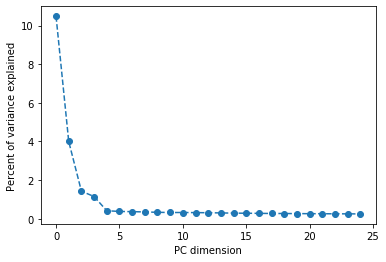

In [12]:
plt.plot(pca_full.explained_variance_ratio_[:25]*100, 'o--')
plt.xlabel('PC dimension')
plt.ylabel('Percent of variance explained')

## t-SNE and UMAP

The following code uses non-PCA methods. We explore t-SNE and UMAP specifically. For t-SNE you can work in 2 or 3 dimensions. You can also specify a variety of hyperparameters (e.g. perplexity to control "tightness" of clusters) but the defaults are sufficient for our purposes.

In [13]:
# Project the genotype data matrix to two dimensions via t-SNE. This may take several minutes to run.
start_time = time.time()
proj_tsne_gt = TSNE(n_components = 2).fit_transform(transposed_genotype_matrix)
end_time = time.time()
print("Run time in seconds: " + str(end_time - start_time))

Run time in seconds: 194.24616312980652


UMAP can project to an arbitrary number of dimensions, but for visualizations we stick to 2. Three-dimensional projections can be interesting too though! The developers recommend using parameter values of 5 to 50 neighbours and a minimum distance between 0.001 and 0.5. We use the default number of neighbours (15) and a minimum distance of 0.5 for clarity in visualizations.

In [14]:
# Project the genotype data matrix to two dimensions via UMAP
start_time = time.time()
proj_umap_gt = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(transposed_genotype_matrix)
end_time = time.time()
print("Run time in seconds: " + str(end_time - start_time))

Run time in seconds: 12.47918701171875


We can also use PCA to pre-process data and reduce the computational load. This is very useful when you have thousands or millions of dimensions, but keep in mind that there could end up being differences between a projection based on the full data and a projection based on the top PCs (Diaz-Papkovich 2019).

In [15]:
# Number of principal components to use
n_pc = 5

In [16]:
# Project the principal components via UMAP to 2 dimensions.
proj_umap_pca = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5).fit_transform(proj_pca[:,:n_pc])

# Visualization

In this section we will generate interactive HTML files that let you select or deselect ethnicities in the projections. You can use the save() command to create a file without viewing it or the show() command to create and open the file. By default, the files will be created in the directory of this notebook.

The three variables to select are the projection to use and the two dimensions you would like to plot against each other. By default we use dimensions 1 and 2 (indexed as 0 and 1 in Python). In PCA we have many dimensions to work with but it can be interesting to look at, say, dimensions 4 vs 1 or 3 vs 2. Our t-SNE and UMAP projections are only 2D so if you want to go into higher dimensions you'll have to specify that and re-run the code. t-SNE only projects to at most 3 dimensions. UMAP projects to an arbitrary number of dimensions.

Note: The HTML files will be 800 high by 1350 wide - you may need to change this to fit into your screen. Otherwise, you can use your browser's native zoom/view options to make things fit.

In [17]:
# Import plotly
import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout

In [18]:
# We would like to use the top 2 PCs. In this case, they are indexed as 0 and 1 in the array proj_pca
in_data = proj_pca
dim1 = 0
dim2 = 1

traces = []

for cont in continents:
    for pop in pop_by_continent[cont]:
        proj_subset = in_data[indices_of_population_members[pop]]

        # Convert the colour string from hex "#xxxxxx" to "(r,g,b)"
        color_string = str(int('0x' + color_dict[pop][1:3].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][3:5].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][5:7].upper(),16))
        
        temp_trace = go.Scattergl(
            x=proj_subset[:,0],
            y=proj_subset[:,1],
            name=name_by_code[pop],
            mode='markers',
            marker=dict(
                size=2,
                color='rgba('+color_string+',0.9)',
                line=dict(
                    color='rgb('+color_string+')',
                    width=2
                )
            )
        )
        traces.append(temp_trace)
        
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='thousand_genomes_chr22_pc1and2.html')

'thousand_genomes_chr22_pc1and2.html'

In [19]:
# Look at the t-SNE projection
in_data = proj_tsne_gt
dim1 = 0
dim2 = 1

traces = []

for cont in continents:
    for pop in pop_by_continent[cont]:
        proj_subset = in_data[indices_of_population_members[pop]]

        # Convert the colour string from hex "#xxxxxx" to "(r,g,b)"
        color_string = str(int('0x' + color_dict[pop][1:3].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][3:5].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][5:7].upper(),16))
        
        temp_trace = go.Scattergl(
            x=proj_subset[:,0],
            y=proj_subset[:,1],
            name=name_by_code[pop],
            mode='markers',
            marker=dict(
                size=2,
                color='rgba('+color_string+',0.9)',
                line=dict(
                    color='rgb('+color_string+')',
                    width=2
                )
            )
        )
        traces.append(temp_trace)
        
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='thousand_genomes_chr22_tsne1and2.html')

'thousand_genomes_chr22_tsne1and2.html'

In [20]:
# Look at the UMAP projection
in_data = proj_umap_gt
dim1 = 0
dim2 = 1

traces = []

for cont in continents:
    for pop in pop_by_continent[cont]:
        proj_subset = in_data[indices_of_population_members[pop]]

        # Convert the colour string from hex "#xxxxxx" to "(r,g,b)"
        color_string = str(int('0x' + color_dict[pop][1:3].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][3:5].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][5:7].upper(),16))
        
        temp_trace = go.Scattergl(
            x=proj_subset[:,0],
            y=proj_subset[:,1],
            name=name_by_code[pop],
            mode='markers',
            marker=dict(
                size=2,
                color='rgba('+color_string+',0.9)',
                line=dict(
                    color='rgb('+color_string+')',
                    width=2
                )
            )
        )
        traces.append(temp_trace)
        
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='thousand_genomes_chr22_umap1and2.html')

'thousand_genomes_chr22_umap1and2.html'

In [21]:
# Look at the UMAP projection of the top PCs
in_data = proj_umap_pca
dim1 = 0
dim2 = 1

traces = []

for cont in continents:
    for pop in pop_by_continent[cont]:
        proj_subset = in_data[indices_of_population_members[pop]]

        # Convert the colour string from hex "#xxxxxx" to "(r,g,b)"
        color_string = str(int('0x' + color_dict[pop][1:3].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][3:5].upper(),16)) + ',' + \
        str(int('0x' + color_dict[pop][5:7].upper(),16))
        
        temp_trace = go.Scattergl(
            x=proj_subset[:,0],
            y=proj_subset[:,1],
            name=name_by_code[pop],
            mode='markers',
            marker=dict(
                size=2,
                color='rgba('+color_string+',0.9)',
                line=dict(
                    color='rgb('+color_string+')',
                    width=2
                )
            )
        )
        traces.append(temp_trace)
        
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=traces, layout=layout)
plotly.offline.plot(fig, filename='thousand_genomes_chr22_umap_on_pca_1and2.html')

'thousand_genomes_chr22_umap_on_pca_1and2.html'

## Discussion

We can see patterns related to ancestry and genetic data. Different dimension reduction methods, inputs, and assumptions will give different results.

Methods like PCA project data to a lower dimensional coordinate plane, ordered in such a way that the first few dimensions explain the most variance. In this case, the top two PCs reflect relationships with continental ancestry, which tends to explain the most variance between populations. Geography is often significantly correlated with ancestry because people tend to find mates who live near them. South Asian individuals fall primarily along a third axis, which is lost when looking at the top two dimensions alone. Individuals with more recently admixed ancestries, such as Central and South Americans, tend to fall in between continental populations because PCA prioritizes maintaining these global distances between, e.g., individuals who have mostly African ancestry versus those who have mostly European ancestry.

Methods like UMAP, on the other hand, work by finding the nearest genetic neighbours and preserving these local neighbourhoods rather than maintaining global distances. This results in a stronger clustering effect with fewer individuals falling "in between", and populations (such as those from South Asia) now appear more distinctly. However, the global distances between different clusters are not meaningful, and these clusterings are sensitive to parameter selection. Selecting a very small number of neighbours will result in many small clusters (often families or cousins), while selecting a very large number will result in larger clusters with sub-clusters visible.

These methods are a good way to examine your data for visualizing different levels of population structure and finding  technical artefacts. It is important to look thoroughly at many aspects of your data, incorporating different parameterizations of different methods. Even here, individuals may fall in one cluster in one visualization and in a different one when using a different approach, so you should be aware that your results will be sensitive to your inputs. The type of data you use (e.g. structural variants, genotype, whole genome, exome, HLA regions, etc.) will result in different visualizations, as will different parameterizations (e.g. number of neighbours or type of distance). While these visualizations are very useful and interesting, one should never rely on visualizations alone to derive conclusions.

## Acknowledgements

This notebook incorporates some code written by Simon Gravel.

### References

* Diaz-Papkovich, Alex, Luke Anderson-Trocmé, Chief Ben-Eghan, and Simon Gravel. "UMAP reveals cryptic population structure and phenotype heterogeneity in large genomic cohorts." PLoS genetics 15.11 (2019).
* Patterson, Nick, Alkes L. Price, and David Reich. "Population structure and eigenanalysis." PLoS genetics 2.12 (2006).